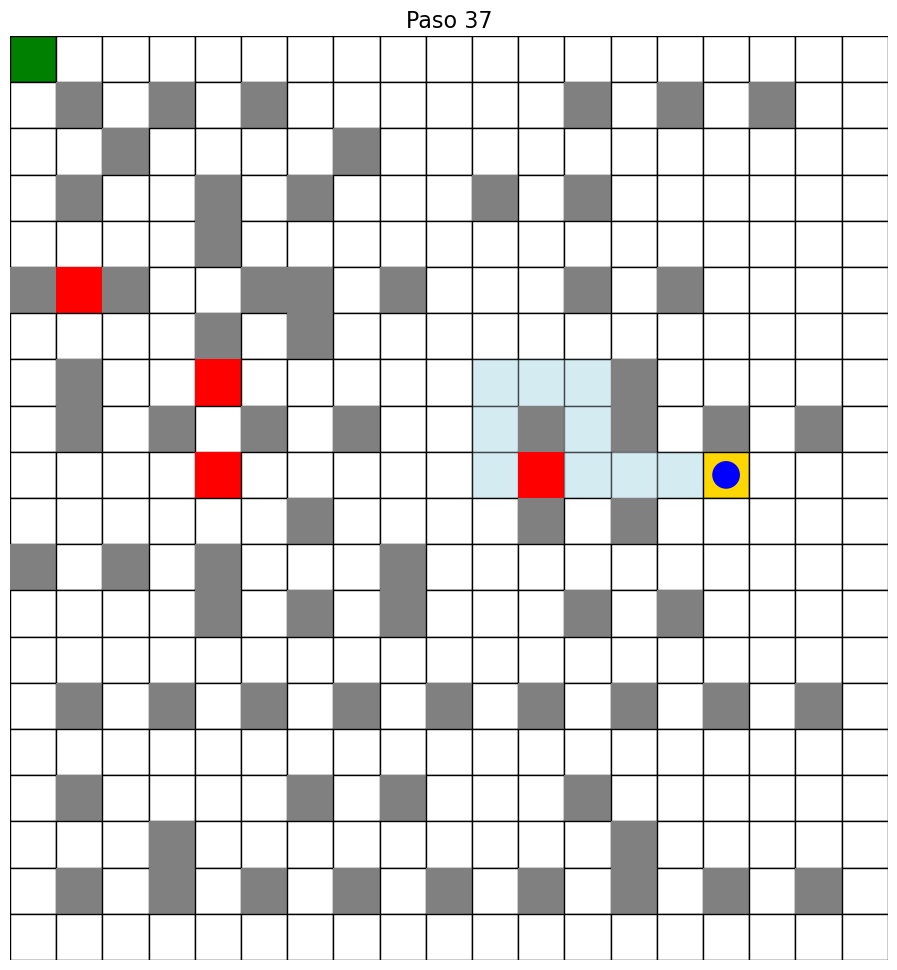

El agente ha llegado a su destino.

Grafo inicial de nodos explorados:


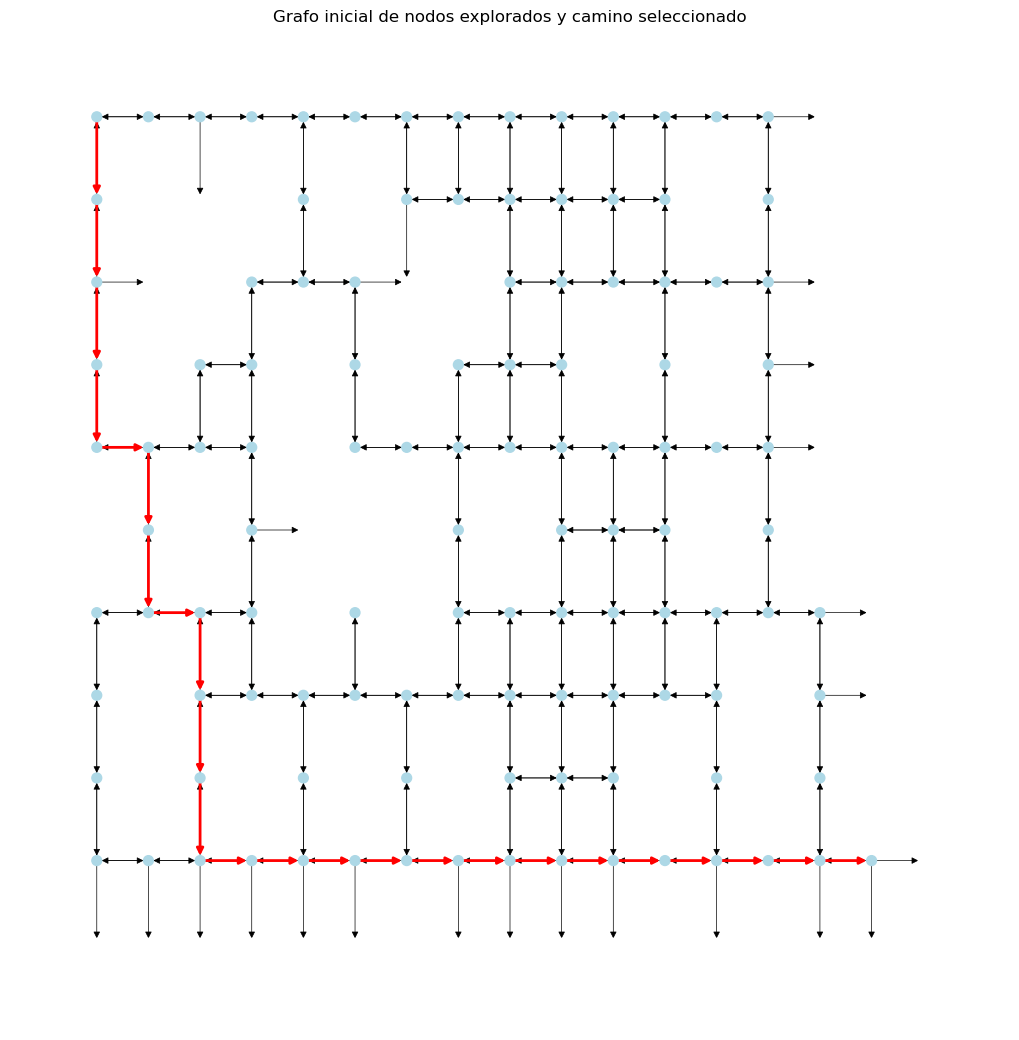

Total de nodos explorados: 113

Grafo después del primer cambio dinámico:


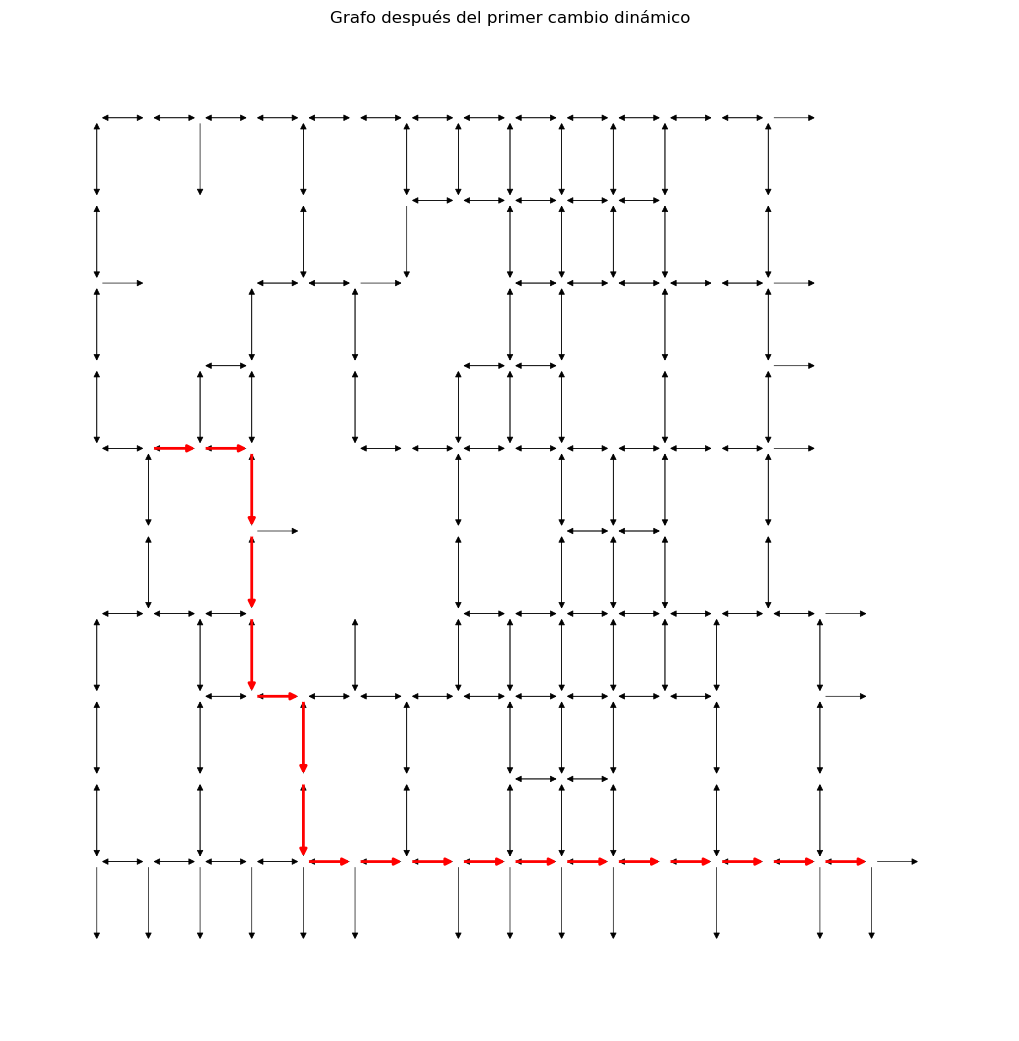

Total de nuevos nodos explorados: 0

Grafo después del segundo cambio dinámico:


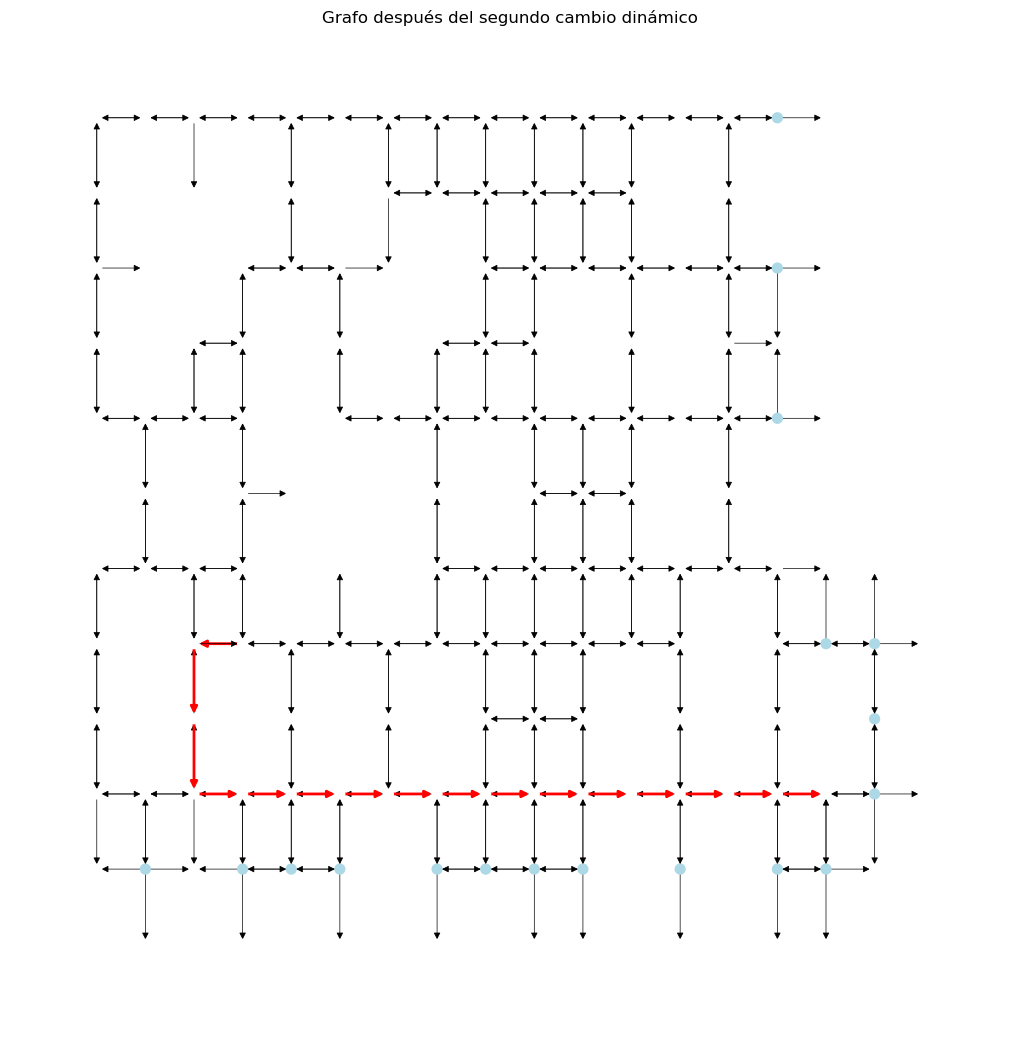

Total de nuevos nodos explorados: 18

Grafo después del tercer cambio dinámico:


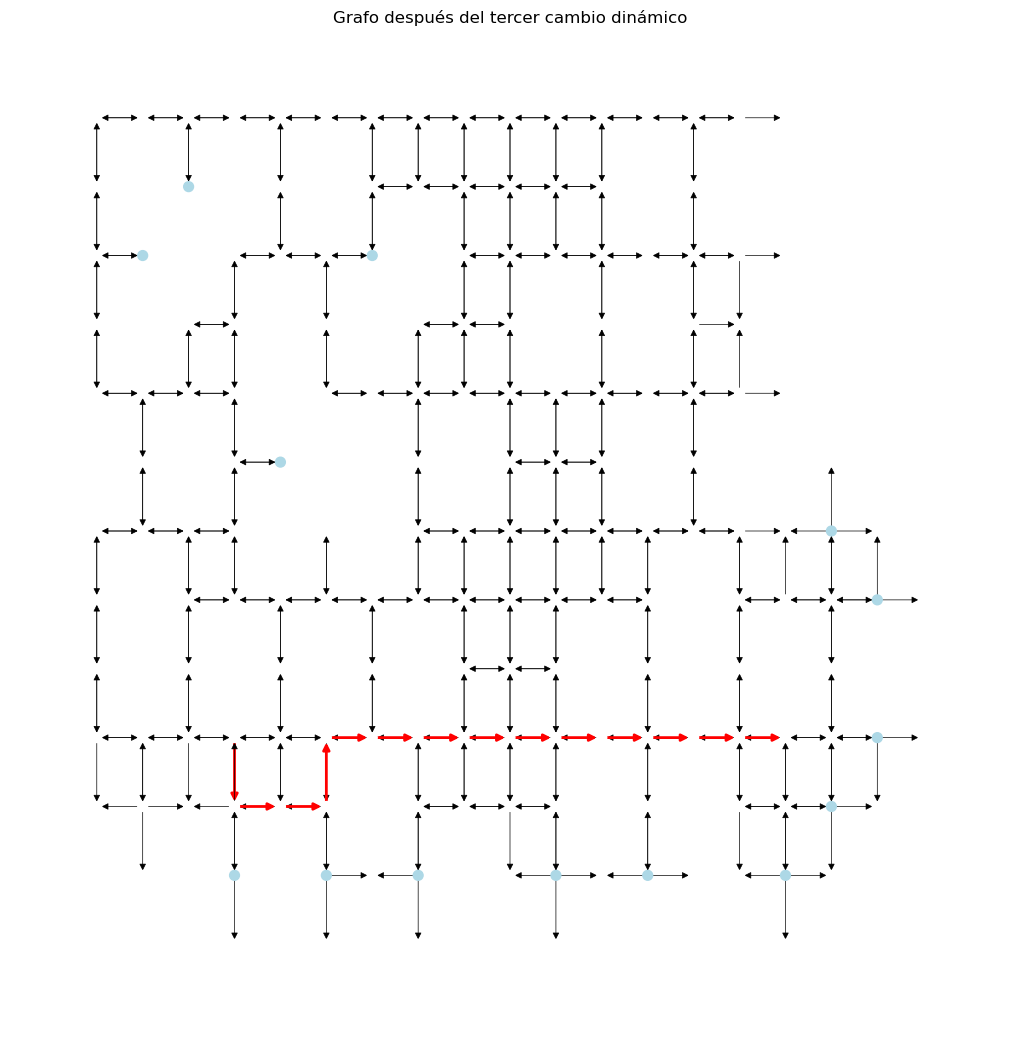

Total de nuevos nodos explorados: 14
Tabla de estados y acciones:
Paso;Posición del Agente;Acción;Costo acumulado (g);Heurística (h);Costo estimado total (f)
0;(0, 0);Inicio;0;24;24
1;(1, 0);Mover Abajo;1;23;24
2;(2, 0);Mover Abajo;2;22;24
3;(3, 0);Mover Abajo;3;21;24
4;(4, 0);Mover Abajo;4;20;24
5;(4, 1);Mover Derecha;5;19;24
6;(4, 1);Mover Desconocido;6;19;25
7;(4, 2);Mover Derecha;7;18;25
8;(4, 3);Mover Derecha;8;17;25
9;(5, 3);Mover Abajo;9;16;25
10;(6, 3);Mover Abajo;10;15;25
11;(7, 3);Mover Abajo;11;14;25
12;(7, 3);Mover Desconocido;12;14;26
13;(7, 2);Mover Izquierda;13;15;28
14;(8, 2);Mover Abajo;14;14;28
15;(9, 2);Mover Abajo;15;13;28
16;(9, 3);Mover Derecha;16;12;28
17;(9, 3);Mover Desconocido;17;12;29
18;(10, 3);Mover Abajo;18;13;31
19;(10, 4);Mover Derecha;19;12;31
20;(10, 5);Mover Derecha;20;11;31
21;(9, 5);Mover Arriba;21;10;31
22;(9, 6);Mover Derecha;22;9;31
23;(9, 7);Mover Derecha;23;8;31
24;(9, 8);Mover Derecha;24;7;31
25;(9, 9);Mover Derecha;25;6;31
26;(9, 10);Mover De

In [15]:
# -----------------------------------------------------
# Proyecto: DynamicMazeAstar
# Autor: GoldHood
# Name: Martin Verastegui
# Mail: martin.verastegui@gmail.com
# Fecha: 29 de octubre de 2024
# Licencia: MIT License
# Descripción: Solucionador de laberintos dinámicos utilizando el algoritmo A* en Python.
# Repositorio: https://github.com/GoldHood/DynamicMazeAstar
# -----------------------------------------------------
# Importamos las librerías necesarias
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import time
from IPython.display import clear_output
import pandas as pd  # Para generar la tabla de pasos

# Definición del laberinto ampliado
initial_maze_data = [
    'S000000000000000000',
    '0x0x0x000000x0x0x00',
    '00x0000x00000000000',
    '0x00x0x000x0x000000',
    '0000x00000000000000',
    'x0x00xx0x000x0x0000',
    '0000x0x000000000000',
    '0x00000000000x00000',
    '0x0x0x0x000x0x0x0x0',
    '000000000000000G000',
    '000000x0000x0x00000',
    'x0x0x000x0000000000',
    '0000x0x0x000x0x0000',
    '0000000000000000000',
    '0x0x0x0x0x0x0x0x0x0',
    '0000000000000000000',
    '0x0000x0x000x000000',
    '000x000000000x00000',
    '0x0x0x0x0x0x0x0x0x0',
    '0000000000000000000'
]

# Ajustamos el laberinto para que todas las filas tengan la misma longitud
max_length = max(len(row) for row in initial_maze_data)
initial_maze_data = [row.ljust(max_length, '0') for row in initial_maze_data]

# Convertimos el laberinto en una matriz
maze = [list(row) for row in initial_maze_data]
rows = len(maze)
cols = len(maze[0])

# Encontramos la posición inicial 'S' y el objetivo 'G'
start = None
goal = None
for i in range(rows):
    for j in range(cols):
        if maze[i][j] == 'S':
            start = (i, j)
        if maze[i][j] == 'G':
            goal = (i, j)

if start is None or goal is None:
    raise ValueError("No se encontró la posición inicial 'S' o la meta 'G' en el laberinto.")

# Movimientos posibles: arriba, abajo, izquierda, derecha
movements = [(-1, 0), (1, 0), (0, -1), (0, 1)]
movement_names = {(-1, 0): "Arriba", (1, 0): "Abajo", (0, -1): "Izquierda", (0, 1): "Derecha"}

# Función para verificar si una posición es válida
def is_valid(maze, x, y):
    if 0 <= x < rows and 0 <= y < cols:
        return maze[x][y] != 'x' and maze[x][y] != 'O'  # No es una pared ni obstáculo dinámico
    return False

# Clase PriorityQueue para D* Lite
class PriorityQueue:
    def __init__(self):
        self.heap = []
        self.entry_finder = {}
        self.REMOVED = '<removed-task>'
        self.counter = 0

    def add_task(self, task, priority):
        'Agrega un nuevo nodo o actualiza su prioridad'
        if task in self.entry_finder:
            self.remove_task(task)
        count = self.counter
        entry = [priority, count, task]
        self.entry_finder[task] = entry
        heapq.heappush(self.heap, entry)
        self.counter += 1

    def remove_task(self, task):
        'Marca un nodo como eliminado'
        entry = self.entry_finder.pop(task)
        entry[-1] = self.REMOVED

    def pop_task(self):
        'Remueve y retorna el nodo con menor prioridad'
        while self.heap:
            priority, count, task = heapq.heappop(self.heap)
            if task is not self.REMOVED:
                del self.entry_finder[task]
                return task
        raise KeyError('pop from an empty priority queue')

    def top_key(self):
        'Retorna la menor clave de prioridad sin removerla'
        while self.heap:
            priority, count, task = self.heap[0]
            if task is self.REMOVED:
                heapq.heappop(self.heap)
                continue
            return priority
        return (float('inf'), float('inf'))

    def empty(self):
        return not any(task is not self.REMOVED for priority, count, task in self.heap)

# Función heurística (distancia Manhattan)
def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Clase DStarLite que implementa el algoritmo D* Lite
class DStarLite:
    def __init__(self, maze, start, goal):
        self.maze = maze
        self.km = 0
        self.start = start
        self.goal = goal
        self.U = PriorityQueue()
        self.rhs = {}
        self.g = {}
        self.parents = {}
        self.last = start

        self.G = nx.DiGraph()  # Grafo para visualización
        self.visited_nodes = set()  # Nodos explorados en cada búsqueda

        for i in range(rows):
            for j in range(cols):
                self.rhs[(i, j)] = float('inf')
                self.g[(i, j)] = float('inf')

        self.rhs[self.goal] = 0
        self.U.add_task(self.goal, self.calculate_key(self.goal))

    def calculate_key(self, s):
        val = min(self.g[s], self.rhs[s])
        return (val + heuristic(self.start, s) + self.km, val)

    def update_vertex(self, u):
        if u != self.goal:
            min_rhs = float('inf')
            for s in self.get_successors(u):
                cost = self.cost(u, s) + self.g[s]
                if cost < min_rhs:
                    min_rhs = cost
                    self.parents[u] = s
            self.rhs[u] = min_rhs
        if u in self.U.entry_finder:
            self.U.remove_task(u)
        if self.g[u] != self.rhs[u]:
            self.U.add_task(u, self.calculate_key(u))

    def compute_shortest_path(self):
        self.visited_nodes = set()  # Reiniciamos los nodos visitados
        while (not self.U.empty() and
               (self.U.top_key() < self.calculate_key(self.start) or self.rhs[self.start] != self.g[self.start])):
            u = self.U.pop_task()
            if self.g[u] > self.rhs[u]:
                self.g[u] = self.rhs[u]
                for s in self.get_predecessors(u):
                    self.update_vertex(s)
                # Añadimos al grafo y a los nodos visitados
                self.visited_nodes.add(u)
                for s in self.get_successors(u):
                    self.G.add_edge(u, s)
            else:
                self.g[u] = float('inf')
                self.update_vertex(u)
                for s in self.get_predecessors(u):
                    self.update_vertex(s)

    def get_predecessors(self, u):
        preds = []
        x, y = u
        for dx, dy in movements:
            nx_, ny_ = x + dx, y + dy
            if is_valid(self.maze, nx_, ny_):
                preds.append((nx_, ny_))
        return preds

    def get_successors(self, u):
        return self.get_predecessors(u)

    def cost(self, a, b):
        if is_valid(self.maze, b[0], b[1]):
            return 1
        else:
            return float('inf')

    def update_start(self, new_start):
        self.km += heuristic(self.last, new_start)
        self.last = new_start
        self.start = new_start

    def update_edge_cost(self, u):
        self.update_vertex(u)
        for s in self.get_predecessors(u):
            self.update_vertex(s)

    def run(self):
        path = [self.start]
        self.compute_shortest_path()
        current = self.start

        while current != self.goal:
            if current not in self.g or self.g[current] == float('inf'):
                print("No hay camino disponible.")
                return None
            successors = self.get_successors(current)
            min_cost = float('inf')
            next_node = None
            for s in successors:
                if self.cost(current, s) + self.g[s] < min_cost:
                    min_cost = self.cost(current, s) + self.g[s]
                    next_node = s
            if next_node is None:
                print("No se puede avanzar.")
                return None
            current = next_node
            path.append(current)
        return path

# Función para dibujar el laberinto y la ruta paso a paso
def draw_maze_step(maze, path, current_step, title=""):
    clear_output(wait=True)
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_title(title, fontsize=16)

    for i in range(rows):
        for j in range(cols):
            cell = maze[i][j]
            x = j
            y = i
            if cell == 'x':
                # Pared
                rect = patches.Rectangle((x, y), 1, 1, facecolor='grey')
                ax.add_patch(rect)
            elif cell == 'O':
                # Obstáculo dinámico
                rect = patches.Rectangle((x, y), 1, 1, facecolor='red')
                ax.add_patch(rect)
            elif cell == 'T':
                # Trampa
                rect = patches.Rectangle((x, y), 1, 1, facecolor='red', edgecolor='black')
                ax.add_patch(rect)
                ax.text(x+0.5, y+0.5, 'T', ha='center', va='center', fontsize=12, color='white')
            elif cell == 'S':
                # Inicio
                rect = patches.Rectangle((x, y), 1, 1, facecolor='green', edgecolor='black')
                ax.add_patch(rect)
            elif cell == 'G':
                # Meta
                rect = patches.Rectangle((x, y), 1, 1, facecolor='gold', edgecolor='black')
                ax.add_patch(rect)
            elif (i, j) in path[:current_step]:
                # Camino recorrido hasta el paso actual
                rect = patches.Rectangle((x, y), 1, 1, facecolor='lightblue', edgecolor='black', alpha=0.5)
                ax.add_patch(rect)
            else:
                # Celda vacía
                rect = patches.Rectangle((x, y), 1, 1, facecolor='white', edgecolor='black')
                ax.add_patch(rect)
    # Posición actual del agente
    if current_step - 1 < len(path):
        current_pos = path[current_step - 1]
        agent_x = current_pos[1] + 0.5
        agent_y = current_pos[0] + 0.5
        agent_circle = patches.Circle((agent_x, agent_y), 0.3, facecolor='blue')
        ax.add_patch(agent_circle)
    plt.show()
    time.sleep(0.2)  # Pausa de 0.2 segundos

# Simulación del desplazamiento del agente con D* Lite
if __name__ == "__main__":
    # Mostrar el entorno inicial
    def draw_maze(maze, title="", agent_pos=None):
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_aspect('equal')
        ax.invert_yaxis()
        ax.axis('off')
        ax.set_title(title, fontsize=16)

        for i in range(rows):
            for j in range(cols):
                cell = maze[i][j]
                x = j
                y = i
                if cell == 'x':
                    # Pared
                    rect = patches.Rectangle((x, y), 1, 1, facecolor='grey')
                    ax.add_patch(rect)
                elif cell == 'O':
                    # Obstáculo dinámico
                    rect = patches.Rectangle((x, y), 1, 1, facecolor='red')
                    ax.add_patch(rect)
                elif cell == 'T':
                    # Trampa
                    rect = patches.Rectangle((x, y), 1, 1, facecolor='red', edgecolor='black')
                    ax.add_patch(rect)
                    ax.text(x+0.5, y+0.5, 'T', ha='center', va='center', fontsize=12, color='white')
                elif cell == 'S':
                    # Inicio
                    rect = patches.Rectangle((x, y), 1, 1, facecolor='green', edgecolor='black')
                    ax.add_patch(rect)
                elif cell == 'G':
                    # Meta
                    rect = patches.Rectangle((x, y), 1, 1, facecolor='gold', edgecolor='black')
                    ax.add_patch(rect)
                else:
                    # Celda vacía
                    rect = patches.Rectangle((x, y), 1, 1, facecolor='white', edgecolor='black')
                    ax.add_patch(rect)
        # Dibujar el agente si se proporciona la posición
        if agent_pos is not None:
            agent_x = agent_pos[1] + 0.5
            agent_y = agent_pos[0] + 0.5
            agent_circle = patches.Circle((agent_x, agent_y), 0.3, facecolor='blue')
            ax.add_patch(agent_circle)
        plt.show()
        time.sleep(0.5)  # Pausa de medio segundo

    draw_maze(maze, title="Entorno Inicial", agent_pos=start)

    # Inicializamos D* Lite
    dstar = DStarLite(maze, start, goal)
    path = dstar.run()

    if path:
        print("Simulación del desplazamiento del agente con D* Lite:")
        step = 1
        global_step = 1  # Contador global de pasos
        dynamic_changes = [6, 12, 17,27,36]  # Lista de pasos globales en los que se agregan obstáculos
        total_nodes_explored = set()
        path_states = []
        table_data = []
        # Guardamos el grafo y nodos explorados iniciales
        initial_graph = dstar.G.copy()
        initial_path_states = path.copy()
        nodes_explored_initial = dstar.visited_nodes.copy()
        cumulative_explored_nodes = dstar.visited_nodes.copy()

        while step < len(path):
            current_pos = path[step - 1]
            draw_maze_step(maze, path, step, title=f"Paso {global_step}")
            path_states.append(current_pos)
            total_nodes_explored.update(dstar.visited_nodes)

            # Agregamos información a la tabla
            if global_step == 1:
                action = 'Inicio'
            else:
                prev_pos = path_states[-2]
                dx = current_pos[0] - prev_pos[0]
                dy = current_pos[1] - prev_pos[1]
                action = 'Mover ' + movement_names.get((dx, dy), 'Desconocido')

            g_value = global_step - 1
            h_value = heuristic(current_pos, goal)
            f_value = g_value + h_value

            table_data.append({
                'Paso': global_step - 1,
                'Posición del Agente': current_pos,
                'Acción': action,
                'Costo acumulado (g)': g_value,
                'Heurística (h)': h_value,
                'Costo estimado total (f)': f_value
            })

            # En los pasos especificados, agregamos nuevos obstáculos
            if global_step in dynamic_changes:
                if step < len(path) - 1:
                    # Añadimos un obstáculo en la posición siguiente del camino planificado
                    obstacle_pos = path[step]
                    maze[obstacle_pos[0]][obstacle_pos[1]] = 'O'  # Usamos 'O' para el obstáculo dinámico
                    print(f"Obstáculo añadido en la posición {obstacle_pos} en el paso {global_step}")
                    # Mostrar el entorno después del cambio con el agente
                    draw_maze(maze, title="Entorno Después del Cambio", agent_pos=current_pos)
                    time.sleep(1)  # Pausa de un segundo para visualizar el cambio
                    # Actualizamos D* Lite con el nuevo entorno
                    dstar.update_start(current_pos)
                    # Informamos al algoritmo de los cambios en los costos
                    dstar.update_edge_cost(obstacle_pos)
                    # Recalculamos el camino
                    path = dstar.run()
                    if path is None:
                        print("No se encontró una ruta alternativa después de añadir el obstáculo.")
                        break
                    step = 1  # Reiniciamos el paso
                    # Guardamos los nodos explorados nuevos en esta fase
                    new_nodes_explored = dstar.visited_nodes - cumulative_explored_nodes
                    cumulative_explored_nodes.update(dstar.visited_nodes)
                    # Guardamos el grafo y el camino después del cambio
                    index_change = dynamic_changes.index(global_step)
                    if index_change == 0:
                        graph_stage1 = dstar.G.copy()
                        path_states_stage1 = path.copy()
                        nodes_explored_stage1 = new_nodes_explored.copy()
                    elif index_change == 1:
                        graph_stage2 = dstar.G.copy()
                        path_states_stage2 = path.copy()
                        nodes_explored_stage2 = new_nodes_explored.copy()
                    elif index_change == 2:
                        graph_stage3 = dstar.G.copy()
                        path_states_stage3 = path.copy()
                        nodes_explored_stage3 = new_nodes_explored.copy()
                    global_step += 1
                    continue  # Volvemos al inicio del while con el nuevo camino
                else:
                    print("No se puede añadir obstáculo en la posición final.")
            else:
                # Actualizamos el inicio en D* Lite
                next_pos = path[step]
                dstar.update_start(next_pos)
            step += 1
            global_step += 1
        else:
            # Último paso
            current_pos = path[-1]
            path_states.append(current_pos)
            draw_maze_step(maze, path, len(path), title=f"Paso {global_step}")
            print("El agente ha llegado a su destino.")
            # Agregar el último paso a la tabla
            g_value = global_step - 1
            h_value = heuristic(current_pos, goal)
            f_value = g_value + h_value
            table_data.append({
                'Paso': global_step - 1,
                'Posición del Agente': current_pos,
                'Acción': 'Llegada',
                'Costo acumulado (g)': g_value,
                'Heurística (h)': h_value,
                'Costo estimado total (f)': f_value
            })

        # Ahora, dibujamos los grafos según lo solicitado

        # Grafo inicial
        print("\nGrafo inicial de nodos explorados:")
        pos = {node: (node[1], -node[0]) for node in initial_graph.nodes()}
        path_edges = list(zip(initial_path_states[:-1], initial_path_states[1:]))
        edge_colors = ['red' if edge in initial_graph.edges() and edge in path_edges else 'black' for edge in initial_graph.edges()]
        edge_widths = [2 if edge in path_edges else 0.5 for edge in initial_graph.edges()]
        node_colors = ['lightblue' if node in nodes_explored_initial else 'white' for node in initial_graph.nodes()]
        plt.figure(figsize=(10, 10))
        nx.draw(initial_graph, pos, node_size=50, node_color=node_colors, with_labels=False, arrows=True,
                edge_color=edge_colors, width=edge_widths)
        plt.title("Grafo inicial de nodos explorados y camino seleccionado")
        plt.show()
        total_nodos = len(nodes_explored_initial)
        print(f"Total de nodos explorados: {total_nodos}")

        # Grafo después del primer cambio dinámico
        if 'graph_stage1' in locals():
            print("\nGrafo después del primer cambio dinámico:")
            pos = {node: (node[1], -node[0]) for node in graph_stage1.nodes()}
            path_edges = list(zip(path_states_stage1[:-1], path_states_stage1[1:]))
            edge_colors = ['red' if edge in graph_stage1.edges() and edge in path_edges else 'black' for edge in graph_stage1.edges()]
            edge_widths = [2 if edge in path_edges else 0.5 for edge in graph_stage1.edges()]
            node_colors = ['lightblue' if node in nodes_explored_stage1 else 'white' for node in graph_stage1.nodes()]
            plt.figure(figsize=(10, 10))
            nx.draw(graph_stage1, pos, node_size=50, node_color=node_colors, with_labels=False, arrows=True,
                    edge_color=edge_colors, width=edge_widths)
            plt.title("Grafo después del primer cambio dinámico")
            plt.show()
            total_nodos = len(nodes_explored_stage1)
            print(f"Total de nuevos nodos explorados: {total_nodos}")

        # Similarmente para el segundo y tercer cambio dinámico...
        if 'graph_stage2' in locals():
            print("\nGrafo después del segundo cambio dinámico:")
            pos = {node: (node[1], -node[0]) for node in graph_stage2.nodes()}
            path_edges = list(zip(path_states_stage2[:-1], path_states_stage2[1:]))
            edge_colors = ['red' if edge in graph_stage2.edges() and edge in path_edges else 'black' for edge in graph_stage2.edges()]
            edge_widths = [2 if edge in path_edges else 0.5 for edge in graph_stage2.edges()]
            node_colors = ['lightblue' if node in nodes_explored_stage2 else 'white' for node in graph_stage2.nodes()]
            plt.figure(figsize=(10, 10))
            nx.draw(graph_stage2, pos, node_size=50, node_color=node_colors, with_labels=False, arrows=True,
                    edge_color=edge_colors, width=edge_widths)
            plt.title("Grafo después del segundo cambio dinámico")
            plt.show()
            total_nodos = len(nodes_explored_stage2)
            print(f"Total de nuevos nodos explorados: {total_nodos}")

        if 'graph_stage3' in locals():
            print("\nGrafo después del tercer cambio dinámico:")
            pos = {node: (node[1], -node[0]) for node in graph_stage3.nodes()}
            path_edges = list(zip(path_states_stage3[:-1], path_states_stage3[1:]))
            edge_colors = ['red' if edge in graph_stage3.edges() and edge in path_edges else 'black' for edge in graph_stage3.edges()]
            edge_widths = [2 if edge in path_edges else 0.5 for edge in graph_stage3.edges()]
            node_colors = ['lightblue' if node in nodes_explored_stage3 else 'white' for node in graph_stage3.nodes()]
            plt.figure(figsize=(10, 10))
            nx.draw(graph_stage3, pos, node_size=50, node_color=node_colors, with_labels=False, arrows=True,
                    edge_color=edge_colors, width=edge_widths)
            plt.title("Grafo después del tercer cambio dinámico")
            plt.show()
            total_nodos = len(nodes_explored_stage3)
            print(f"Total de nuevos nodos explorados: {total_nodos}")

        # Generamos y mostramos la tabla
        df = pd.DataFrame(table_data)
        pd.set_option('display.max_colwidth', None)
        print("Tabla de estados y acciones:")
        print(df.to_csv(sep=';', index=False))
    else:
        print("No se encontró una solución.")
